In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Tue Jan 23 19:30:14 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   30C    P0    42W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive2_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0.9999

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_exclusive2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 11758, model_list, optimizer_list)

total 8
-rw-rw-r-- 1 scpark scpark 40  1월 23 19:30 events.out.tfevents.1706005731.GPUSVR11
-rw-rw-r-- 1 scpark scpark 40  1월 23 19:30 events.out.tfevents.1706005734.GPUSVR11


In [7]:
# path = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform/save_240000'
# checkpoint = torch.load(path, map_location=torch.device('cpu'))
# # warm start
# for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
#     model.load_state_dict(checkpoint['models_state_dict'][i], strict=True)
#     optimizer.load_state_dict(checkpoint['optimizers_state_dict'][i])
    
# print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

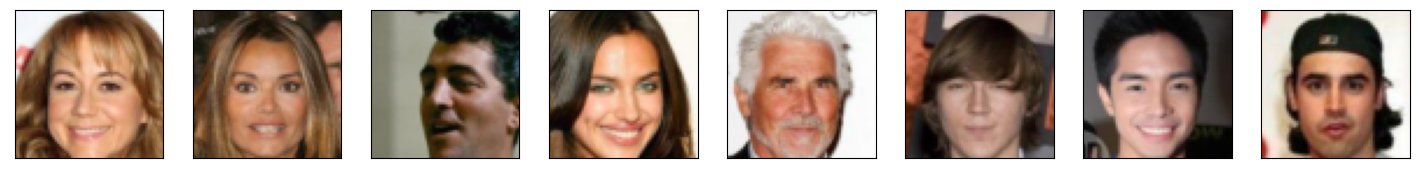

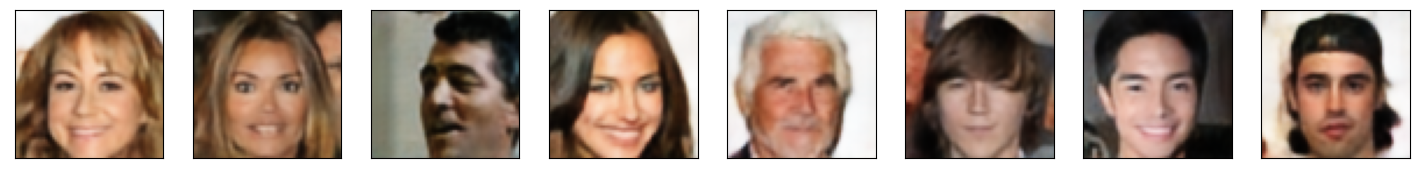

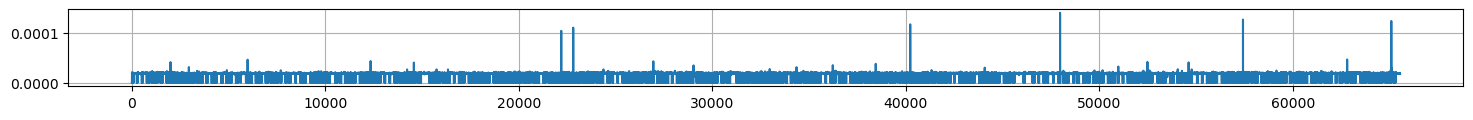

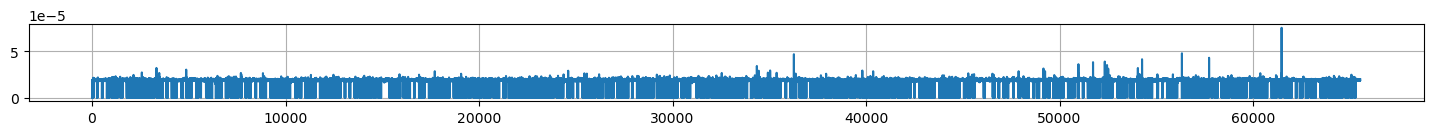

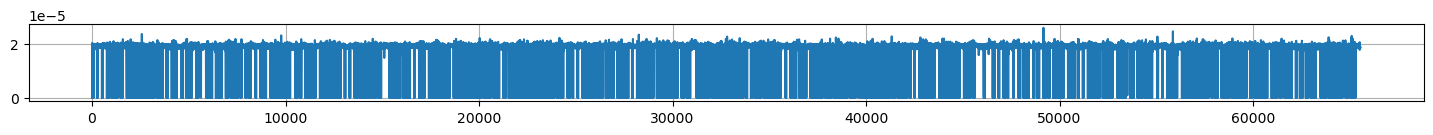

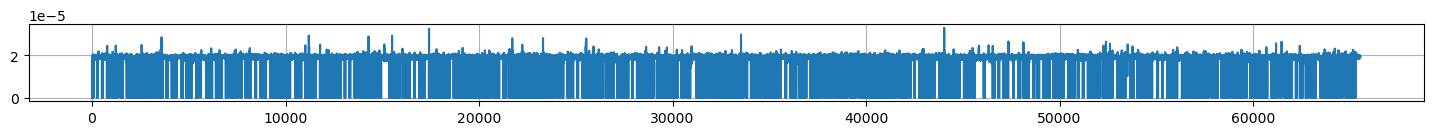

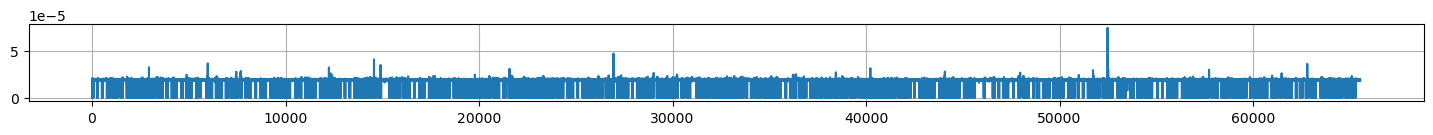

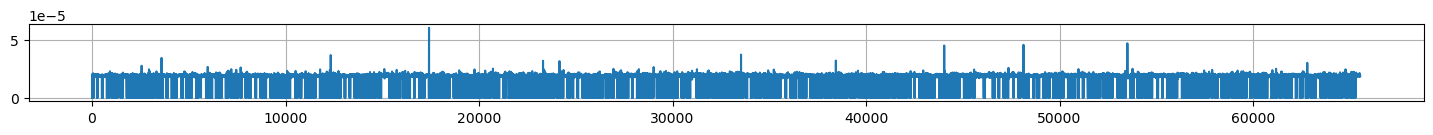

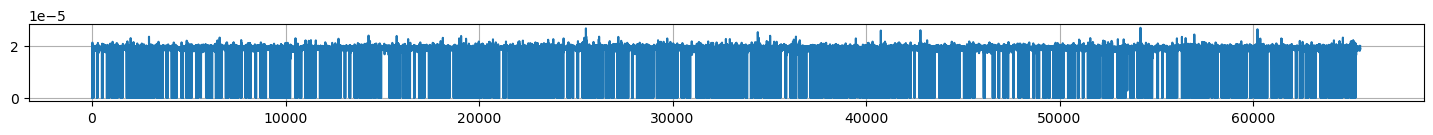

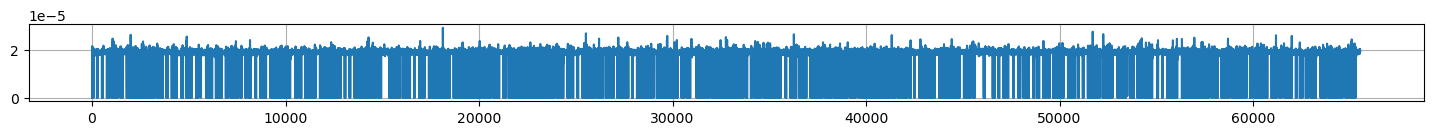

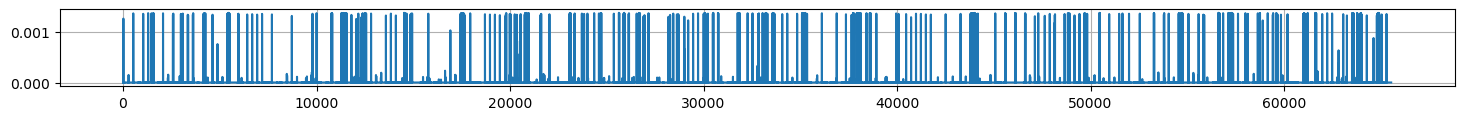

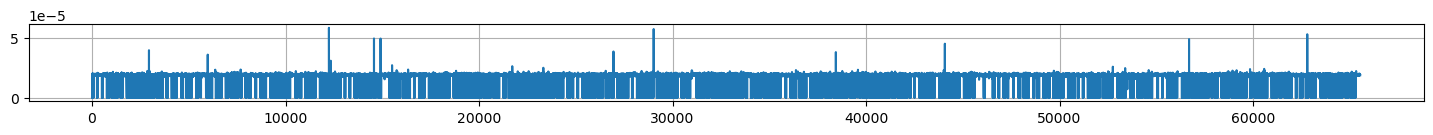

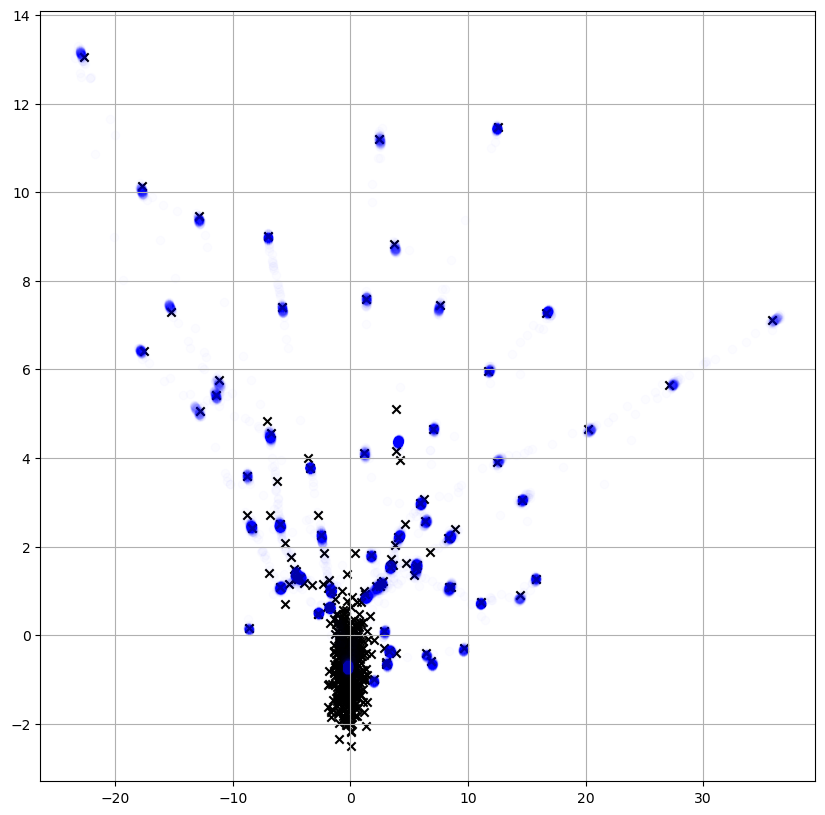

4001
lse_loss -21.709430694580078
commit_loss 0.0005185895715840161
recon_loss 0.0013069286942481995
4002
lse_loss -21.709388732910156
commit_loss 0.00048354396130889654
recon_loss 0.001233105082064867
4003
lse_loss -21.70846176147461
commit_loss 0.0005007364088669419
recon_loss 0.0013758041895925999
4004
lse_loss -21.709400177001953
commit_loss 0.0004711256187874824
recon_loss 0.0011851214803755283
4005
lse_loss -21.706382751464844
commit_loss 0.0005906057776883245
recon_loss 0.0012699784711003304
4006
lse_loss -21.70977783203125
commit_loss 0.000447649450507015
recon_loss 0.0012848806800320745
4007
lse_loss -21.704360961914062
commit_loss 0.000624236068688333
recon_loss 0.0014034295454621315
4008
lse_loss -21.710491180419922
commit_loss 0.000455237808637321
recon_loss 0.0013503250665962696
4009
lse_loss -21.71094512939453
commit_loss 0.0004535062180366367
recon_loss 0.0012049453798681498
4010
lse_loss -21.709407806396484
commit_loss 0.00046017623390071094
recon_loss 0.001362427137792

4083
lse_loss -21.710128784179688
commit_loss 0.0004239164409227669
recon_loss 0.0012473729439079762
4084
lse_loss -21.7049560546875
commit_loss 0.0006056862766854465
recon_loss 0.0013013487914577127
4085
lse_loss -21.711193084716797
commit_loss 0.0004235454834997654
recon_loss 0.00124724383931607
4086
lse_loss -21.709991455078125
commit_loss 0.0004753920657094568
recon_loss 0.0012509434018284082
4087
lse_loss -21.710590362548828
commit_loss 0.00044876401079818606
recon_loss 0.0012396852253004909
4088
lse_loss -21.709197998046875
commit_loss 0.0004990949528291821
recon_loss 0.0012447759509086609
4089
lse_loss -21.710277557373047
commit_loss 0.00045053212670609355
recon_loss 0.0012387530878186226
4090
lse_loss -21.709579467773438
commit_loss 0.0004360171442385763
recon_loss 0.0013465909287333488
4091
lse_loss -21.710472106933594
commit_loss 0.0004320340813137591
recon_loss 0.0012623139191418886
4092
lse_loss -21.706451416015625
commit_loss 0.000582991458941251
recon_loss 0.0012850639177

4165
lse_loss -21.70895004272461
commit_loss 0.0004397750017233193
recon_loss 0.0012206574901938438
4166
lse_loss -21.706218719482422
commit_loss 0.0004794168926309794
recon_loss 0.0012047465424984694
4167
lse_loss -21.708133697509766
commit_loss 0.0005006955470889807
recon_loss 0.0012218845076858997
4168
lse_loss -21.709197998046875
commit_loss 0.0004793152620550245
recon_loss 0.0011770552955567837
4169
lse_loss -21.708141326904297
commit_loss 0.00043901868048124015
recon_loss 0.0012349741300567985
4170
lse_loss -21.70736312866211
commit_loss 0.0004810316604562104
recon_loss 0.0012554472777992487
4171
lse_loss -21.708240509033203
commit_loss 0.00047635097871534526
recon_loss 0.0012177525786682963
4172
lse_loss -21.71004867553711
commit_loss 0.0003921565366908908
recon_loss 0.0011618547141551971
4173
lse_loss -21.709075927734375
commit_loss 0.0003806795575655997
recon_loss 0.0012186341919004917
4174
lse_loss -21.707725524902344
commit_loss 0.00047985577839426696
recon_loss 0.0012768316

4247
lse_loss -21.706871032714844
commit_loss 0.0005055303336121142
recon_loss 0.001358715584501624
4248
lse_loss -21.708206176757812
commit_loss 0.0004557234642561525
recon_loss 0.0012429517228156328
4249
lse_loss -21.70473861694336
commit_loss 0.0005083021824248135
recon_loss 0.001225705724209547
4250
lse_loss -21.707534790039062
commit_loss 0.0004611964104697108
recon_loss 0.0012384788133203983
4251
lse_loss -21.707164764404297
commit_loss 0.0005231030518189073
recon_loss 0.0013087836559861898
4252
lse_loss -21.70801544189453
commit_loss 0.0004522736126091331
recon_loss 0.0012646338436752558
4253
lse_loss -21.700469970703125
commit_loss 0.0006472914246842265
recon_loss 0.0012395139783620834
4254
lse_loss -21.707374572753906
commit_loss 0.0005362211959436536
recon_loss 0.0013271275674924254
4255
lse_loss -21.707107543945312
commit_loss 0.0004887518589384854
recon_loss 0.0012158846948295832
4256
lse_loss -21.707794189453125
commit_loss 0.0004841989139094949
recon_loss 0.00122244679369

4329
lse_loss -21.706527709960938
commit_loss 0.0004820717149414122
recon_loss 0.0011976718669757247
4330
lse_loss -21.705829620361328
commit_loss 0.0004895791644230485
recon_loss 0.0012691712472587824
4331
lse_loss -21.706279754638672
commit_loss 0.0005053469212725759
recon_loss 0.0012468143831938505
4332
lse_loss -21.700942993164062
commit_loss 0.0007121431408450007
recon_loss 0.0015950737288221717
4333
lse_loss -21.707733154296875
commit_loss 0.0004429066029842943
recon_loss 0.001195813762024045
4334
lse_loss -21.706623077392578
commit_loss 0.0004701516008935869
recon_loss 0.0013395672431215644
4335
lse_loss -21.707534790039062
commit_loss 0.0004224908770993352
recon_loss 0.001288722618483007
4336
lse_loss -21.700069427490234
commit_loss 0.0005982104921713471
recon_loss 0.0013254061341285706
4337
lse_loss -21.707748413085938
commit_loss 0.00042091868817806244
recon_loss 0.001248410320840776
4338
lse_loss -21.70630645751953
commit_loss 0.0004683138686232269
recon_loss 0.0013556358171

4411
lse_loss -21.706092834472656
commit_loss 0.0004751513770315796
recon_loss 0.0012286020210012794
4412
lse_loss -21.705909729003906
commit_loss 0.00048173326649703085
recon_loss 0.0012607753742486238
4413
lse_loss -21.704345703125
commit_loss 0.0005122364964336157
recon_loss 0.0013077559415251017
4414
lse_loss -21.706024169921875
commit_loss 0.00045076574315316975
recon_loss 0.0011902109254151583
4415
lse_loss -21.701595306396484
commit_loss 0.0005549706984311342
recon_loss 0.0012748769950121641
4416
lse_loss -21.70568084716797
commit_loss 0.0004497296758927405
recon_loss 0.001295213820412755
4417
lse_loss -21.705326080322266
commit_loss 0.00047073233872652054
recon_loss 0.0012497608549892902
4418
lse_loss -21.703689575195312
commit_loss 0.0005801968509331346
recon_loss 0.0012553686974570155
4419
lse_loss -21.70562744140625
commit_loss 0.000442377757281065
recon_loss 0.001290155341848731
4420
lse_loss -21.704837799072266
commit_loss 0.0005175588885322213
recon_loss 0.001239108503796

4493
lse_loss -21.705432891845703
commit_loss 0.0004592766927089542
recon_loss 0.00122978282161057
4494
lse_loss -21.70264434814453
commit_loss 0.0005310426349751651
recon_loss 0.0013390386011451483
4495
lse_loss -21.704708099365234
commit_loss 0.00045412417966872454
recon_loss 0.0011669788509607315
4496
lse_loss -21.703712463378906
commit_loss 0.0005213236436247826
recon_loss 0.001243768259882927
4497
lse_loss -21.702999114990234
commit_loss 0.000515354098752141
recon_loss 0.0012460597790777683
4498
lse_loss -21.705055236816406
commit_loss 0.0004526147968135774
recon_loss 0.0011712778359651566
4499
lse_loss -21.704673767089844
commit_loss 0.0004864457587245852
recon_loss 0.0012103971093893051
4500
lse_loss -21.705608367919922
commit_loss 0.0004458976909518242
recon_loss 0.0013456109445542097
4501
lse_loss -21.70383071899414
commit_loss 0.0005045421421527863
recon_loss 0.0011966921156272292
4502
lse_loss -21.702136993408203
commit_loss 0.0005792599404230714
recon_loss 0.001260892022401

4575
lse_loss -21.70520782470703
commit_loss 0.00040525777149014175
recon_loss 0.0012400803389027715
4576
lse_loss -21.702266693115234
commit_loss 0.0005323798977769911
recon_loss 0.0012979679740965366
4577
lse_loss -21.702896118164062
commit_loss 0.0005027914885431528
recon_loss 0.001250445144250989
4578
lse_loss -21.704803466796875
commit_loss 0.0004440781776793301
recon_loss 0.001159162726253271
4579
lse_loss -21.700504302978516
commit_loss 0.0006263047689571977
recon_loss 0.0013854026328772306
4580
lse_loss -21.701622009277344
commit_loss 0.000541487243026495
recon_loss 0.0012749182060360909
4581
lse_loss -21.703887939453125
commit_loss 0.0005038621602579951
recon_loss 0.001316993497312069
4582
lse_loss -21.702346801757812
commit_loss 0.0005323445075191557
recon_loss 0.0012860270217061043
4583
lse_loss -21.702228546142578
commit_loss 0.0005123323062434793
recon_loss 0.0012226428370922804
4584
lse_loss -21.703102111816406
commit_loss 0.0005257542943581939
recon_loss 0.00121776014566

4657
lse_loss -21.703956604003906
commit_loss 0.00045973603846505284
recon_loss 0.0012840330600738525
4658
lse_loss -21.70360565185547
commit_loss 0.0004613370983861387
recon_loss 0.0012954500271007419
4659
lse_loss -21.70306396484375
commit_loss 0.000497247267048806
recon_loss 0.0012288412544876337
4660
lse_loss -21.70376205444336
commit_loss 0.0005130006466060877
recon_loss 0.0012535443529486656
4661
lse_loss -21.70323944091797
commit_loss 0.0005082766292616725
recon_loss 0.0011997700203210115
4662
lse_loss -21.70453643798828
commit_loss 0.0005099193076603115
recon_loss 0.0013552752789109945
4663
lse_loss -21.703292846679688
commit_loss 0.0004695590469054878
recon_loss 0.001320748939178884
4664
lse_loss -21.703319549560547
commit_loss 0.0004935235483571887
recon_loss 0.0013487308751791716
4665
lse_loss -21.704151153564453
commit_loss 0.0004715928516816348
recon_loss 0.0012996260775253177
4666
lse_loss -21.703399658203125
commit_loss 0.0004712937225122005
recon_loss 0.0013085256796330

4739
lse_loss -21.69906997680664
commit_loss 0.0005893547204323113
recon_loss 0.001197007717564702
4740
lse_loss -21.703350067138672
commit_loss 0.000454084511147812
recon_loss 0.0012030251091346145
4741
lse_loss -21.70287322998047
commit_loss 0.000493593281134963
recon_loss 0.0012918623397126794
4742
lse_loss -21.702301025390625
commit_loss 0.0004987150896340609
recon_loss 0.0012959204614162445
4743
lse_loss -21.69896697998047
commit_loss 0.0005497197853401303
recon_loss 0.00125599792227149
4744
lse_loss -21.701370239257812
commit_loss 0.0004868880205322057
recon_loss 0.001178581966087222
4745
lse_loss -21.702590942382812
commit_loss 0.0004905052483081818
recon_loss 0.0013209031894803047
4746
lse_loss -21.701087951660156
commit_loss 0.000555624661501497
recon_loss 0.001224141102284193
4747
lse_loss -21.70150375366211
commit_loss 0.0004977948265150189
recon_loss 0.0012057911371812224
4748
lse_loss -21.70345687866211
commit_loss 0.00043439987348392606
recon_loss 0.0012628819094970822
47

4821
lse_loss -21.70148468017578
commit_loss 0.0004630819894373417
recon_loss 0.0012310113525018096
4822
lse_loss -21.70345687866211
commit_loss 0.00045130803482607007
recon_loss 0.0012084520421922207
4823
lse_loss -21.70246124267578
commit_loss 0.0004736968840006739
recon_loss 0.0012297945795580745
4824
lse_loss -21.702171325683594
commit_loss 0.0005230180686339736
recon_loss 0.001225863117724657
4825
lse_loss -21.70206069946289
commit_loss 0.0004537021741271019
recon_loss 0.0014025093987584114
4826
lse_loss -21.700809478759766
commit_loss 0.0005544915911741555
recon_loss 0.0011694771237671375
4827
lse_loss -21.700458526611328
commit_loss 0.0004983536200597882
recon_loss 0.0013057588366791606
4828
lse_loss -21.702362060546875
commit_loss 0.0004896047757938504
recon_loss 0.0013938233023509383
4829
lse_loss -21.69867706298828
commit_loss 0.0005465231370180845
recon_loss 0.0012418631231412292
4830
lse_loss -21.69955062866211
commit_loss 0.0005005721468478441
recon_loss 0.0013130772858858

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            softmax_temp = linear(1, 0, step, 0, 100*1000)
            data = model(data, latent_temp=1, softmax_temp=softmax_temp)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')